Exception at frame 0: not enough values to unpack (expected 3, got 2)


IndexError: list index out of range

Exception at frame 0: not enough values to unpack (expected 3, got 2)
Error in callback <function _draw_all_if_interactive at 0x1772e5a20> (for post_execute), with arguments args (),kwargs {}:


ValueError: not enough values to unpack (expected 3, got 2)

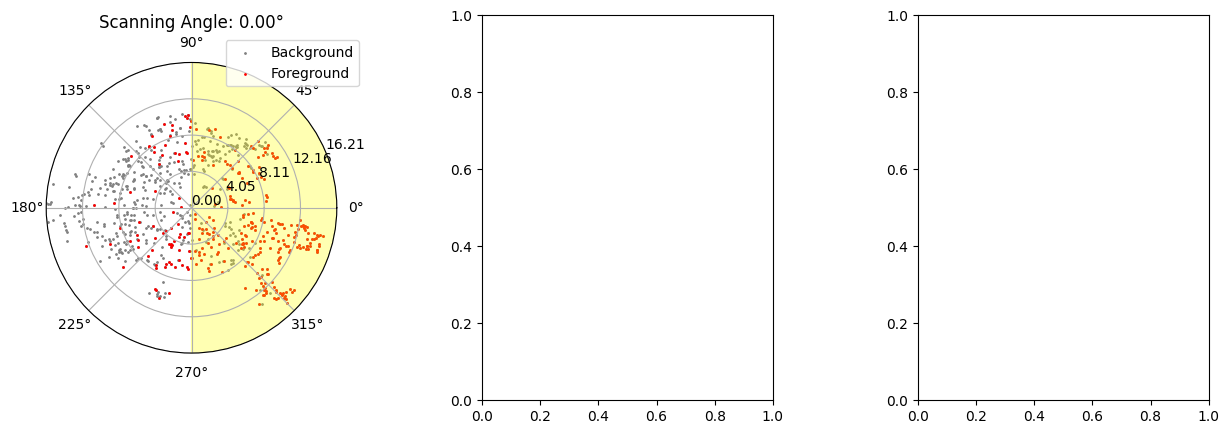

In [22]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Import the updated functions from the biorsp module
from ipynb.fs.full.biorsp import (
    find_foreground_background_points,
    convert_to_polar,
    in_scanning_range,
    compute_cdfs,
    # Other functions if needed
)

# Create 'animations' directory if it doesn't exist
os.makedirs("animations", exist_ok=True)

# Load your data
dge_matrix = pd.read_csv("data/MCA2_filtered.dge.txt", sep="\t", index_col=0)
tsne_results = pd.read_csv("embeddings/tsne_results.csv").to_numpy()
dbscan_results = pd.read_csv("embeddings/tsne_dbscan_results.csv")

# Define parameters
gene_name = "Tnnt2"
threshold = 10
clusters = [1]
scanning_window = np.pi
num_scanning_angles = 360  # Number of frames in animation
num_bins_within_window = 1000  # Number of bins within scanning window
num_bins_total = 1000  # Number of bins for the full range 0 to 2π
angle_range = np.array([0.0, 2.0 * np.pi])
mode = "absolute"

# Find foreground and background points
foreground_points, background_points = find_foreground_background_points(
    gene_name=gene_name,
    dge_matrix=dge_matrix,
    tsne_results=tsne_results,
    threshold=threshold,
    dbscan_df=dbscan_results,
    selected_clusters=clusters,
)

# Set the vantage point
vantage_point = background_points.mean(axis=0)

# Convert points to polar coordinates
fg_r, fg_theta = convert_to_polar(foreground_points, vantage_point)
bg_r, bg_theta = convert_to_polar(background_points, vantage_point)

# Ensure angles are within [0, 2π]
fg_theta = fg_theta % (2 * np.pi)
bg_theta = bg_theta % (2 * np.pi)

# Calculate scanning angles
theta_min = angle_range[0]
theta_max = angle_range[1]
theta_k_list = (
    theta_min
    + np.arange(num_scanning_angles) * (theta_max - theta_min) / num_scanning_angles
)

# Determine the maximum radius for the scanning window
radius_max = max(np.max(fg_r), np.max(bg_r))

# Set up the figure and axes for animation
fig = plt.figure(figsize=(15, 5))  # Increased width to accommodate third panel
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1], wspace=0.5)
ax1 = fig.add_subplot(gs[0], projection="polar")
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

# Function to plot the scanning window on the polar plot
def plot_scanning_window(ax, start_angle, end_angle, radius_max):
    # Handle wrap-around
    if start_angle < end_angle:
        theta_window = np.linspace(start_angle, end_angle, 100)
    else:
        # Wrap-around case
        theta_window = np.linspace(start_angle, end_angle + 2 * np.pi, 100)
        theta_window = theta_window % (2 * np.pi)
    # Create the corresponding r values
    r_window = np.full_like(theta_window, radius_max)
    # Add the origin to close the polygon
    theta_polygon = np.concatenate(
        ([start_angle], theta_window, [end_angle], [start_angle])
    )
    r_polygon = np.concatenate(([0], r_window, [0], [0]))
    # Plot the scanning window
    ax.fill(theta_polygon, r_polygon, color="yellow", alpha=0.3)

# Updated animate function with cumulative RSP differences
def animate(i):
    try:
        angle = theta_k_list[i]
        start_angle = 0.0  # Start from 0 degrees
        end_angle = angle  # End at the current angle

        # Handle wrapping if end_angle exceeds 2π
        if end_angle > 2 * np.pi:
            end_angle = end_angle % (2 * np.pi) + 2 * np.pi

        ax1.clear()
        ax2.clear()
        ax3.clear()  # Clear the third axis

        # Radar scanning demo (Left Side) - Polar Plot
        # Plot background points
        ax1.scatter(bg_theta, bg_r, color="grey", s=1, label="Background")
        # Plot foreground points
        ax1.scatter(fg_theta, fg_r, color="red", s=1, label="Foreground")

        # Highlight scanning window
        plot_scanning_window(
            ax1,
            (angle - scanning_window / 2) % (2 * np.pi),
            (angle + scanning_window / 2) % (2 * np.pi),
            radius_max,
        )

        ax1.set_ylim(0, radius_max)
        ax1.set_title(f"Scanning Angle: {np.degrees(angle)%360:.2f}°")
        ax1.grid(True)
        ax1.set_xticks(np.linspace(0, 2 * np.pi, 8, endpoint=False))
        ax1.set_yticks(np.linspace(0, radius_max, 5))
        ax1.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))

        # Compute CDFs for the current scanning window (Middle Panel)
        fg_in_window = in_scanning_range(fg_theta, angle, scanning_window)
        bg_in_window = in_scanning_range(bg_theta, angle, scanning_window)

        fg_projection = fg_theta[fg_in_window]
        bg_projection = bg_theta[bg_in_window]

        # Compute histograms and CDFs for the scanning window
        fg_cdf, bg_cdf, bin_edges = compute_cdfs(
            fg_projection,
            bg_projection,
            angle,
            scanning_window,
            num_bins_within_window,
            mode,
        )

        # Adjust bin edges for plotting
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers

        # CDFs plot (Middle Panel)
        ax2.clear()
        if np.any(bg_cdf):
            ax2.step(
                bin_centers,
                bg_cdf,
                where="mid",
                color="grey",
                label="Background CDF",
            )

        if np.any(fg_cdf):
            ax2.step(
                bin_centers,
                fg_cdf,
                where="mid",
                color="red",
                label="Foreground CDF",
            )

        # Handle case when there is no foreground data
        if not np.any(fg_cdf):
            ax2.text(
                0.5,
                0.5,
                "No Foreground Data in this window",
                horizontalalignment="center",
                verticalalignment="center",
                transform=ax2.transAxes,
            )

        ax2.legend()
        ax2.set_xlabel("Angle (radians)")
        ax2.set_ylabel("CDF")
        ax2.set_title("CDFs within Scanning Window")
        ax2.set_xlim(bin_centers[0], bin_centers[-1])
        ax2.set_ylim(0, 1)
        ax2.grid(True)
        ax2.set_aspect(aspect="auto", adjustable="box")

        # Compute cumulative RSP differences (Third Panel)
        # Select data within the cumulative angle range
        if start_angle < end_angle:
            fg_in_cumulative = (fg_theta >= start_angle) & (fg_theta <= end_angle)
            bg_in_cumulative = (bg_theta >= start_angle) & (bg_theta <= end_angle)
        else:
            # Handle wrapping around 2π
            fg_in_cumulative = (fg_theta >= start_angle) | (fg_theta <= end_angle % (2 * np.pi))
            bg_in_cumulative = (bg_theta >= start_angle) | (bg_theta <= end_angle % (2 * np.pi))

        fg_projection_cumulative = fg_theta[fg_in_cumulative]
        bg_projection_cumulative = bg_theta[bg_in_cumulative]

        # Compute histograms and CDFs for the cumulative range
        fg_cdf_cum, bg_cdf_cum, bin_edges_cum = compute_cdfs(
            fg_projection_cumulative,
            bg_projection_cumulative,
            start_angle,
            end_angle,
            num_bins_total,
            mode,
        )

        # Adjust bin edges for plotting
        bin_centers_cum = (bin_edges_cum[:-1] + bin_edges_cum[1:]) / 2  # Compute bin centers

        # Compute RSP differences
        rsp_diff_cum = fg_cdf_cum - bg_cdf_cum

        # Plot the cumulative RSP differences
        ax3.clear()
        ax3.plot(bin_centers_cum, rsp_diff_cum, color="blue", label="RSP Difference")

        # Reference line at zero
        ax3.axhline(0, color='black', linewidth=0.5, linestyle='--')
        ax3.legend()
        ax3.set_xlabel("Angle (radians)")
        ax3.set_ylabel("Difference")
        ax3.set_title("Cumulative RSP Differences")
        ax3.set_xlim(0, 2 * np.pi)
        ax3.set_ylim(-1, 1)
        ax3.grid(True)
        ax3.set_aspect(aspect="auto", adjustable="box")
        ax3.set_xticks(np.linspace(0, 2 * np.pi, 9))
        ax3.set_xticklabels([f"{int(np.degrees(tick)%360)}°" for tick in ax3.get_xticks()])

    except Exception as e:
        print(f"Exception at frame {i}: {e}")
        raise e  # Re-raise the exception to stop the animation

# Create the animation
anim = FuncAnimation(fig, animate, frames=num_scanning_angles, interval=100)

# Save the animation as a GIF
anim.save(f"animations/{gene_name}_rsp_animation.gif", writer="pillow", fps=10)